# Customer Clustering and Spending Predictions
---

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from yellowbrick.cluster import KElbowVisualizer

### Initial Data and Cleaning
---

In [96]:
df = pd.read_csv('./data/marketing_campaign.csv', delimiter='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [97]:
df.shape

(2240, 29)

All data is accounted for except income.  To keep it simple, we will impute the mean into missing income.

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

As a personal preference I will make all column names lower case for easier typing.

In [99]:
df.columns = [x.lower() for x in df.columns]

In [100]:
mean_income = df['income'].mean()
mean_income

52247.25135379061

In [101]:
df['income'].fillna(mean_income, inplace=True)

### Feature Engineering
---

Features to engineer:
1. Customer involvement duration - how long has a customer been enrolled with the company
2. Total dependants - combined teens and children
3. Total spent - total amount spent across all categories
4. Customer age - how old the customer is
5. Partners - determine if the person is single or living with someone.
6. Total household size - total number of people in the household including parterns and children
7. Parental status - boolean column to identify parents
8. Total promos - total number of promotions accepted

First we must convert out 'dt_customer' column to proper datetime format.

In [102]:
df['dt_customer'] = pd.to_datetime(df['dt_customer'])

In order to get the account's age, we will subtract each account creation date from the newest account's date.

In [103]:
newest_acc = df['dt_customer'].max()
newest_acc

Timestamp('2014-12-06 00:00:00')

Loop through every account's creation date and subract the newest account's date to get the age of the account.

In [104]:
acc_age = []
for i in df['dt_customer']:
    diff = newest_acc - i
    acc_age.append(diff)

df['acc_age'] = acc_age
df['acc_age'] = pd.to_numeric(df['acc_age'].dt.days, downcast='integer')

Let's check the column to make sure it's displaying properly.  Looks good!

In [105]:
df['acc_age']

0       971
1       125
2       472
3        65
4       321
       ... 
2235    541
2236     61
2237    315
2238    316
2239    782
Name: acc_age, Length: 2240, dtype: int16

Next we will engineer the remainder of our features.

In [106]:
# total combined number of children (children plus teens)
df['total_children'] = df['kidhome'] + df['teenhome']

# total spent across all product categories
df['total_spent'] = df['mntwines'] + df['mntfruits'] + df['mntmeatproducts'] + df['mntfishproducts'] + df['mntsweetproducts'] + df['mntgoldprods']

# user's age
df['age'] = 2021 - df['year_birth']

# whether the person is living alone or with a partner (not including children)
df['partner'] = df['marital_status'].replace({'Married':1, 'Together':1, 'Absurd':0, 'Widow':0, 'YOLO':0, 'Divorced':0, 'Single':0, 'Alone': 0})
df['partner'] = [int(x) for x in df['partner']]

# total number of people in the household including the user, potential partner, and/or children
df['household_size'] = df['partner'].replace({1:2, 0:1}) + df['total_children']

# a boolean column identifying whether the person is a parent or not
df['parent'] = np.where(df['total_children'] > 1, 1, 0)

# total number of promotions accepted
df["total_promos"] = df["acceptedcmp1"]+ df["acceptedcmp2"]+ df["acceptedcmp3"]+ df["acceptedcmp4"]+ df["acceptedcmp5"]

Finally, we'll drop some redudant columns that no longer serve a purpose now that we've engineered some to be more useful features.

In [107]:
df.drop(columns=['marital_status', 'dt_customer', 'z_costcontact', 'z_revenue', 'year_birth', 'id'], inplace=True)
df.head()

,education,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,...,complain,response,acc_age,total_children,total_spent,age,partner,household_size,parent,total_promos
0,Graduation,58138.0,0,0,58,635,88,546,172,88,...,0,1,971,0,1617,64,0,1,0,0
1,Graduation,46344.0,1,1,38,11,1,6,2,1,...,0,0,125,2,27,67,0,3,1,0
2,Graduation,71613.0,0,0,26,426,49,127,111,21,...,0,0,472,0,776,56,1,2,0,0
3,Graduation,26646.0,1,0,26,11,4,20,10,3,...,0,0,65,1,53,37,1,3,0,0
4,PhD,58293.0,1,0,94,173,43,118,46,27,...,0,0,321,1,422,40,1,3,0,0


### EDA
---

We have some very wealthy patrons throwing off our histogram, but we can see most of our users' incomes follow a relatively normal distribution between 0 and $100,000

In [108]:
df.columns

Index(['education', 'income', 'kidhome', 'teenhome', 'recency', 'mntwines',
       'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts',
       'mntgoldprods', 'numdealspurchases', 'numwebpurchases',
       'numcatalogpurchases', 'numstorepurchases', 'numwebvisitsmonth',
       'acceptedcmp3', 'acceptedcmp4', 'acceptedcmp5', 'acceptedcmp1',
       'acceptedcmp2', 'complain', 'response', 'acc_age', 'total_children',
       'total_spent', 'age', 'partner', 'household_size', 'parent',
       'total_promos'],
      dtype='object')

In [109]:
cleaned_income = df[df['income'] < 200000]

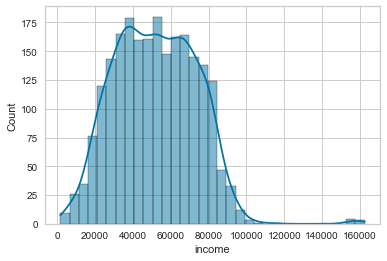

In [110]:
sns.histplot(cleaned_income['income'], kde=True);

A uniform distribution of the number of days between when a person purchased an item.  No clear pattern or bell curve here.

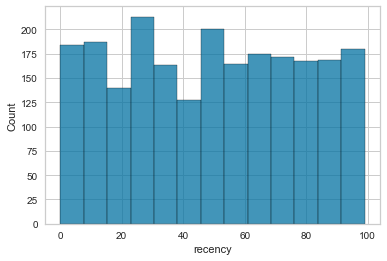

In [111]:
sns.histplot(df['recency']);

Distribution of the total household size is relatively regular.  Most households are between 2 and 4 people indicating:
1. Most users are couples or single parents with a single child
2. Most users are a couple with multiple children or a single parent with multiple children

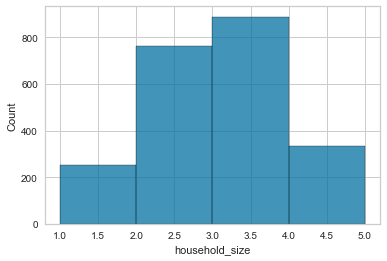

In [112]:
sns.histplot(df['household_size'], bins=4);

The distribution of age is not perfectly clear but we can see a vast majority of users are between 45-50 years old.

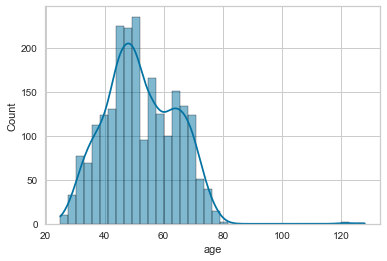

In [113]:
sns.histplot(df['age'], kde=True);

Comparing income to spending and removing folks who make over 200k, we can see a logarithmic increase in spending as income goes up, peaking between those who make $80k - 100k

For our modeling purposes later we will need to consider removing the additional income outliers above $120k.

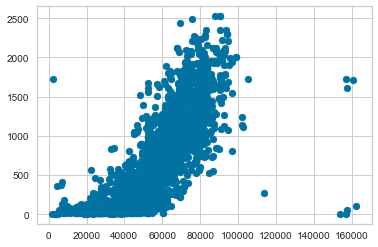

In [114]:
plt.scatter(cleaned_income['income'], cleaned_income['total_spent']);

I'm curious if there are any correlation between people purchasing certain items together, so we'll make a heatmap and examine those possible correlations.  These may be disposable correlations since people likely tend to buy multiple items, but the strongest correlations we might want to consider are:
1. Wine and meat
2. Fruit and fish
3. Fruit and sweets

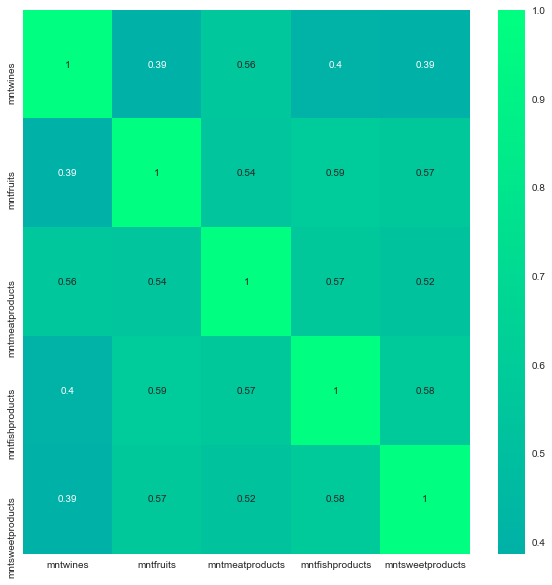

In [115]:
corrmat= df.iloc[:, 5:10].corr()
plt.figure(figsize=(10,10))  
sns.heatmap(corrmat,annot=True, cmap='winter', center=0);

In [116]:
df = df[df['income'] < 200000]

In [117]:
df.shape

(2239, 31)

In [118]:
df.reset_index(inplace=True)

### Pre-processing
---

Before modeling there are a handful of things that need to happen:
- Encode our non-numerical and categorical variables
- Scale our data
- Dimensionality reduction

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2239 entries, 0 to 2238
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                2239 non-null   int64  
 1   education            2239 non-null   object 
 2   income               2239 non-null   float64
 3   kidhome              2239 non-null   int64  
 4   teenhome             2239 non-null   int64  
 5   recency              2239 non-null   int64  
 6   mntwines             2239 non-null   int64  
 7   mntfruits            2239 non-null   int64  
 8   mntmeatproducts      2239 non-null   int64  
 9   mntfishproducts      2239 non-null   int64  
 10  mntsweetproducts     2239 non-null   int64  
 11  mntgoldprods         2239 non-null   int64  
 12  numdealspurchases    2239 non-null   int64  
 13  numwebpurchases      2239 non-null   int64  
 14  numcatalogpurchases  2239 non-null   int64  
 15  numstorepurchases    2239 non-null   i

Our only categorical column that needs to be dummied is income so we'll use Pandas' built in dummy feature to encode that column.

In [120]:
df = pd.get_dummies(df, columns=['education'])
df.head()

,index,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,...,age,partner,household_size,parent,total_promos,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD
0,0,58138.0,0,0,58,635,88,546,172,88,...,64,0,1,0,0,0,0,1,0,0
1,1,46344.0,1,1,38,11,1,6,2,1,...,67,0,3,1,0,0,0,1,0,0
2,2,71613.0,0,0,26,426,49,127,111,21,...,56,1,2,0,0,0,0,1,0,0
3,3,26646.0,1,0,26,11,4,20,10,3,...,37,1,3,0,0,0,0,1,0,0
4,4,58293.0,1,0,94,173,43,118,46,27,...,40,1,3,0,0,0,0,0,0,1


Next we will scale our data.

In [121]:
sc = StandardScaler()
scaled_df = sc.fit_transform(df)

We now have 34 total features, many of which are correlated and therefore unneccessary to us.  To refine our data we will perform PCA, or principal component analysis to find the most important features.  It looks like the PCA algorithm reduced our dimensions from 34 to 18, meaning 18 of our features fit into the specified 95% variance requirement.

In [122]:
pca = PCA(n_components = 0.95)
pca.fit(scaled_df)
reduced = pd.DataFrame(pca.transform(scaled_df))
reduced.shape

(2239, 25)

Since we will be clustering to find our different user groups, we want to find the ideal number of clusters.  We will use the elbow method to find this number.

From the below graph, it appears that 5 will be the optimal number for us.  However, after running these models with 5 clusters, 4 seemed to have more consistent groupings and peformance. 

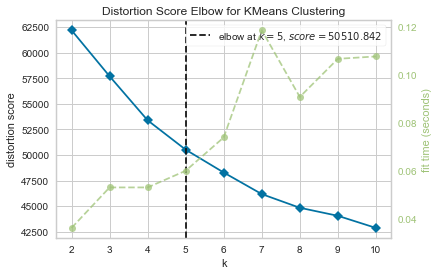

In [123]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(reduced)
Elbow_M.show();

In [124]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(reduced)
reduced["clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df["clusters"]= yhat_AC

Checking the distribution of our clusters. We can see that a vast majority of users fall into group 1 and 2 with a consistent decline after that.

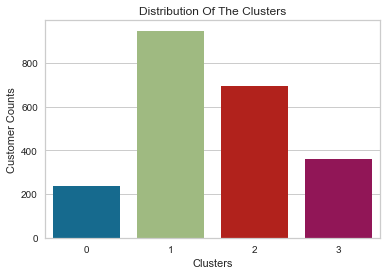

In [141]:
pl = sns.countplot(x=df["clusters"])
pl.set_title("Distribution Of The Clusters")
pl.set_xlabel("Clusters")
pl.set_ylabel("Customer Count")
plt.show()

Next, let's explore the clusters distributed by income and spending.

From the below graph we can infer:
- Group 0: high income and medium spending
- Group 1: low income and low spending
- Group 2: high income and high spending
- Group 3: medium income and low spending

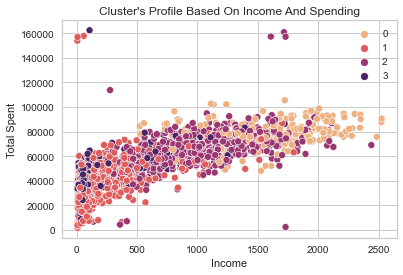

In [127]:
pl = sns.scatterplot(data = df,x=df["total_spent"], y=df["income"],hue=df["clusters"], palette='flare')
pl.set_title("Cluster's Profile Based On Income And Spending")
pl.set_xlabel('Income')
pl.set_ylabel('Total Spent')
plt.legend()
plt.show()

Promotions and coupons draw in a lot of business, often times getting people's feet in the door to make more purchases while taking advantage of the promotion.  Let's see how our groups interact with our promotions.

It appears that most people did not take advantage of promotions.

Solutions:
1. Target promotions more accurately to the correct audience.
2. Target high popularity items to draw more people
3. Depending on inventory, target low selling items to move them

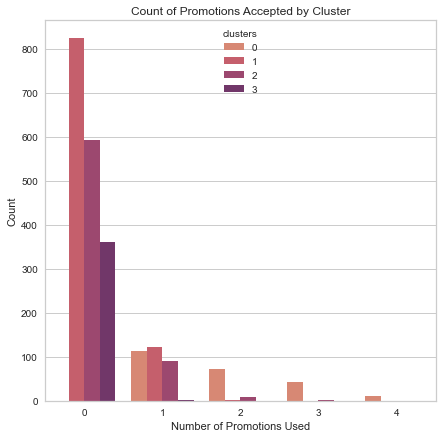

In [128]:
plt.figure(figsize=(7,7))
pl = sns.countplot(x=df['total_promos'], hue=df['clusters'], palette='flare')
pl.set_title('Count of Promotions Accepted by Cluster')
pl.set_xlabel('Number of Promotions Used')
pl.set_ylabel('Count')
plt.show();

Deals on the other hand are utilized much more often by customers, seeing a resounding number of users using 1 or 2 deals with 3-7 trailing off consistently.  This is a much more successful tool for customer engagement.

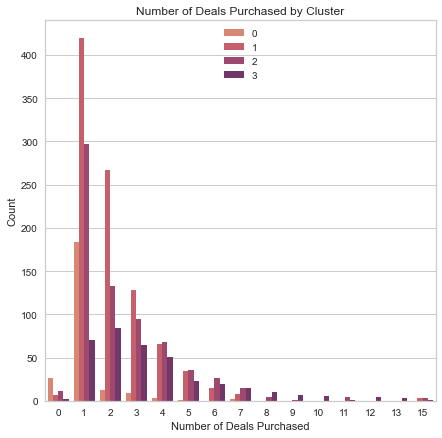

In [129]:
plt.figure(figsize=(7,7))
pl = sns.countplot(x=df['numdealspurchases'], hue=df['clusters'], palette='flare')
pl.set_title('Number of Deals Purchased by Cluster')
pl.set_xlabel('Number of Deals Purchased')
pl.set_ylabel('Count')
plt.legend(loc = 'upper center')
plt.show();

### Cluster/Segmentation Exploration
---

We'll make a consolidated dataframe with useful information to draw some inferences.

In [130]:
cols = ['income', 'total_spent', 'age', 'acc_age', 'parent', 'partner', 'total_children', 'numdealspurchases', 'total_promos', 'clusters']
segmentation_df = df[cols]
segmentation_df.head()

,income,total_spent,age,acc_age,parent,partner,total_children,numdealspurchases,total_promos,clusters
0,58138.0,1617,64,971,0,0,0,3,0,2
1,46344.0,27,67,125,1,0,2,2,0,3
2,71613.0,776,56,472,0,1,0,1,0,2
3,26646.0,53,37,65,0,1,1,2,0,1
4,58293.0,422,40,321,0,1,1,5,0,1


In [131]:
segmentation_df.shape

(2239, 10)

In [132]:
cluster_0_df = segmentation_df[segmentation_df['clusters'] == 0]
cluster_1_df = segmentation_df[segmentation_df['clusters'] == 1]
cluster_2_df = segmentation_df[segmentation_df['clusters'] == 2]
cluster_3_df = segmentation_df[segmentation_df['clusters'] == 3]

In [133]:
cluster_0_avg = cluster_0_df.mean()
cluster_1_avg = cluster_1_df.mean()
cluster_2_avg = cluster_2_df.mean()
cluster_3_avg = cluster_3_df.mean()

cluster_avg_df = pd.DataFrame(columns=cols)

In [134]:
cluster_avg_df = cluster_avg_df.append(cluster_0_avg, ignore_index=True)
cluster_avg_df = cluster_avg_df.append(cluster_1_avg, ignore_index=True)
cluster_avg_df = cluster_avg_df.append(cluster_2_avg, ignore_index=True)
cluster_avg_df = cluster_avg_df.append(cluster_3_avg, ignore_index=True)

cluster_avg_df.head()

,income,total_spent,age,acc_age,parent,partner,total_children,numdealspurchases,total_promos,clusters
0,79333.602953,1562.260504,52.445378,498.243697,0.012605,0.668067,0.168067,1.126050,1.802521,0.0
1,37339.846637,197.965153,49.111932,493.381204,0.090813,0.662091,0.918691,2.071806,0.133052,1.0
2,66219.718985,1028.264069,54.398268,552.255411,0.036075,0.600289,0.655123,2.440115,0.160173,2.0
3,44971.411380,235.590028,55.905817,492.470914,0.997230,0.667590,2.116343,3.554017,0.002770,3.0


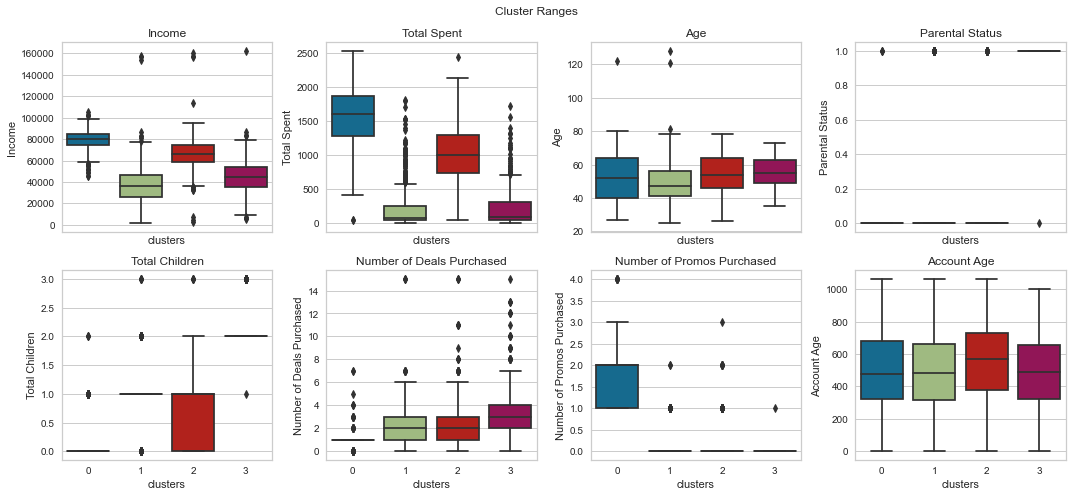

In [135]:
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(15,7))

fig.suptitle('Cluster Ranges')

sns.boxplot(ax=axes[0, 0], x='clusters', y=segmentation_df['income'], data=segmentation_df)
axes[0, 0].set_title('Income')
axes[0, 0].set_ylabel('Income')

sns.boxplot(ax=axes[0, 1], x='clusters', y=segmentation_df['total_spent'], data=segmentation_df)
axes[0, 1].set_title('Total Spent')
axes[0, 1].set_ylabel('Total Spent')

sns.boxplot(ax=axes[0, 2], x='clusters', y=segmentation_df['age'], data=segmentation_df)
axes[0, 2].set_title('Age')
axes[0, 2].set_ylabel('Age')

sns.boxplot(ax=axes[0, 3], x='clusters', y=segmentation_df['parent'], data=segmentation_df)
axes[0, 3].set_title('Parental Status')
axes[0, 3].set_ylabel('Parental Status')

sns.boxplot(ax=axes[1, 0], x='clusters', y=segmentation_df['total_children'], data=segmentation_df)
axes[1, 0].set_title('Total Children')
axes[1, 0].set_ylabel('Total Children')

sns.boxplot(ax=axes[1, 1], x='clusters', y=segmentation_df['numdealspurchases'], data=segmentation_df)
axes[1, 1].set_title('Number of Deals Purchased')
axes[1, 1].set_ylabel('Number of Deals Purchased')

sns.boxplot(ax=axes[1, 2], x='clusters', y=segmentation_df['total_promos'], data=segmentation_df)
axes[1, 2].set_title('Number of Promos Purchased')
axes[1, 2].set_ylabel('Number of Promos Purchased')

sns.boxplot(ax=axes[1, 3], x='clusters', y=segmentation_df['acc_age'], data=segmentation_df)
axes[1, 3].set_title('Account Age')
axes[1, 3].set_ylabel('Account Age')

plt.tight_layout()
plt.show();

Let's explore some of our ranges by displaying our data in boxplots:

**Inferences:**

1) Income:
    - Four distinct income groups in order from highest to lowest: 0, 2, 3, 1


2) Total spent:
    - Three distinct groups with 0 and 2 standing out at the biggest spenders with 1 and 3 in similar ranges with some notable outliers   




3) Age:
    - Group 0 has the widest range by far, but overall we see similar mean ages.


4) Parental status:
    - This is a boolean column so we won't see much range, however, we can glean that groups 0, 1, and 2 have fewer parents among there where as group 3 is prodominantly parents


5) Total children:
    - This graph shows a similar story in most groups have tight ranges, except group 2.  
    - Group 0 has few children, group 1 has rougly 1 child per household, group 2 has between 0 and 1 which some having as many as 2, and lastly group 3 has an average of 2 childrne per household.




6) Number of deals purchased:
    - This is important one for us
    - Our highest spending group doesn't utilize many deals
    - Groups 1 and 2 are very similar in their range and usage of deals
    - Group 3 has the second highest income but takes advantage of the most deals
    


7) Number of promos purchased:
    - Another important feature
    - Interestingly, group 1 didn't use many deals but they took advantage of far more promos than any other group between 1 and 2 on average.


 
8) Account age:
    - Nothing terribly useful here, most accounts are close to the same age with group 2 being slightly higher on average.

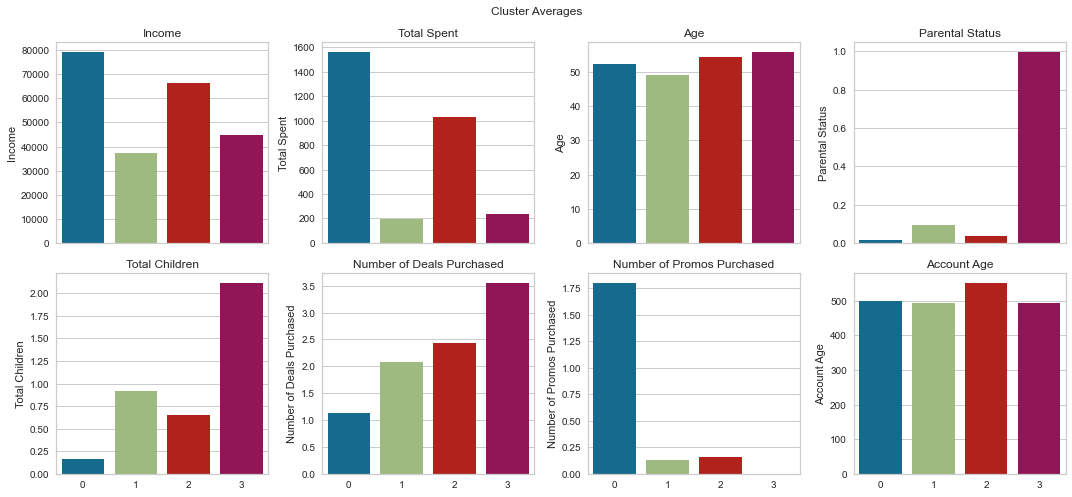

In [136]:
fig, axes = plt.subplots(2, 4, sharex=True, figsize=(15,7))

fig.suptitle('Cluster Averages')

sns.barplot(ax=axes[0, 0], x=cluster_avg_df.index, y=cluster_avg_df['income'])
axes[0, 0].set_title('Income')
axes[0, 0].set_ylabel('Income')

sns.barplot(ax=axes[0, 1], x=cluster_avg_df.index, y=cluster_avg_df['total_spent'])
axes[0, 1].set_title('Total Spent')
axes[0, 1].set_ylabel('Total Spent')

sns.barplot(ax=axes[0, 2], x=cluster_avg_df.index, y=cluster_avg_df['age'])
axes[0, 2].set_title('Age')
axes[0, 2].set_ylabel('Age')

sns.barplot(ax=axes[0, 3], x=cluster_avg_df.index, y=cluster_avg_df['parent'])
axes[0, 3].set_title('Parental Status')
axes[0, 3].set_ylabel('Parental Status')

sns.barplot(ax=axes[1, 0], x=cluster_avg_df.index, y=cluster_avg_df['total_children'])
axes[1, 0].set_title('Total Children')
axes[1, 0].set_ylabel('Total Children')

sns.barplot(ax=axes[1, 1], x=cluster_avg_df.index, y=cluster_avg_df['numdealspurchases'])
axes[1, 1].set_title('Number of Deals Purchased')
axes[1, 1].set_ylabel('Number of Deals Purchased')

sns.barplot(ax=axes[1, 2], x=cluster_avg_df.index, y=cluster_avg_df['total_promos'])
axes[1, 2].set_title('Number of Promos Purchased')
axes[1, 2].set_ylabel('Number of Promos Purchased')

sns.barplot(ax=axes[1, 3], x=cluster_avg_df.index, y=cluster_avg_df['acc_age'])
axes[1, 3].set_title('Account Age')
axes[1, 3].set_ylabel('Account Age')

plt.tight_layout()
plt.show();

For a more viewer friendly we can use these bar graphs that show us the averages to get snap shot of how our groups look.  All previous statements from the boxplot analysis hold true with these graphs, they're just a little bit easier on the eyes.

### Overall Cluster Demographic Traits
---

In [137]:
cluster_0_count = cluster_0_df.shape[0]
cluster_1_count = cluster_1_df.shape[0]
cluster_2_count = cluster_2_df.shape[0]
cluster_3_count = cluster_3_df.shape[0]

total_count = segmentation_df.shape[0]

In [138]:
print(f'Cluster 0 total customer count is: {cluster_0_count} or {round(cluster_0_count/total_count*100, 2)}%')
print(f'Cluster 1 total customer count is: {cluster_1_count} or {round(cluster_1_count/total_count*100, 2)}%')
print(f'Cluster 2 total customer count is: {cluster_2_count} or {round(cluster_2_count/total_count*100, 2)}%')
print(f'Cluster 3 total customer count is: {cluster_3_count} or {round(cluster_3_count/total_count*100, 2)}%')

Cluster 0 total customer count is: 238 or 10.63%
Cluster 1 total customer count is: 947 or 42.3%
Cluster 2 total customer count is: 693 or 30.95%
Cluster 3 total customer count is: 361 or 16.12%


In [139]:
cluster_0_spent = sum(cluster_0_df['total_spent'])
cluster_1_spent = sum(cluster_1_df['total_spent'])
cluster_2_spent = sum(cluster_2_df['total_spent'])
cluster_3_spent = sum(cluster_3_df['total_spent'])

total_spent = sum(segmentation_df['total_spent'])

In [140]:
print(f'Cluster 0 revenue is: ${cluster_0_spent} or {round(cluster_0_spending/total_spent*100, 2)}% of total revenue')
print(f'Cluster 1 revenue is: ${cluster_1_spent} or {round(cluster_1_spending/total_spent*100, 2)}% of total revenue')
print(f'Cluster 2 revenue is: ${cluster_2_spent} or {round(cluster_2_spending/total_spent*100, 2)}% of total revenue')
print(f'Cluster 3 revenue is: ${cluster_3_spent} or {round(cluster_3_spending/total_spent*100, 2)}% of total revenue')

Cluster 0 revenue is: $371818 or 27.4% of total revenue
Cluster 1 revenue is: $187473 or 13.82% of total revenue
Cluster 2 revenue is: $712587 or 52.51% of total revenue
Cluster 3 revenue is: $85048 or 6.27% of total revenue


0 = 1562.26
1 = 197.96
2 = 1028.26
3 = 235.59

**Cluster 0:**

1. 238 users, 10.63% of total users, smallest group
2. Highest average income
3. Average spent per user ~$1,562.26
4. Second highest revenue generating group at \$371,181, or 27.4% of total revenue
5. Widest range of ages
6. Few to no children
7. Low interest in deals - about 1 utilized on average
8. High interest in promos - about 2 utilized on average

**Inferences:**
1. Wealthy
2. High spending
3. Diverse ages
4. Childless
5. Attracted to promos
6. Second highest revenue generators

---

**Cluster 1:**

1. 947 users, 42.3% of total users, largest group
2. Lowest average income
3. Average spent per user ~$197.96, lowest per user spending of all groups - low spending per user counter-acted by large group size
4. Second lowest revenue generating group at \$187,473 or 13.82% total revenue 
5. Youngest group
6. Most households have about 1 child on average
7. Low interested in deals - about 2 utilized on average
8. Low interest in promos - less than 1 utilized on average

**Inferences:**
1. Low income
2. Low spending
3. Young
4. Likely new parents
5. Some interest in deals
6. Low priority group unless we can attract them with deals or special targetted products

---

**Cluster 2:**

1. 693 users, 30.95% of total users, third largest group
2. Second highest average income
3. Average spent per user ~\$1,028.26, second highest per user spending of all groups
4. Highest revenue generating group at \$712,587 or 52.51% of total revnue
5. Tighter spread of ages between 44 - 63
6. Most households have 1 or no children
7. Medium interest in deals - about 2.5 utilized on average
8. Low interest in promos - less than 1 utilized on average

**Inferences:**
1. Wealthy
2. High spending
3. Older
4. Middle aged parents
5. Attracted to deals
6. High priority group to draw in with deals
7. Highest revenue drivers by far

---

**Cluster 3:**

1. 361 users, 16.12% of total users, second smallest group
2. Second lowest average income
3. Average spent per user ~$235.59, second lowest per user spending of all groups
4. Lowest revenue generating group at \$85,048 or 6.27% of total revnue
5. Oldest group on average
6. Most households have at least 2 children
7. Highest interest in deals - about 3.5 utilized on average
8. Almost no utilization of promos

**Inferences:**
1. Medium income
2. Low spending
3. Older folks
4. Almost all families with multiple children
5. Medium priority group, highly interested in deals